In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.tight_layout()
plt.style.use('seaborn-v0_8-darkgrid')

from utils import train_lda_model, load_bow

# gensim
from gensim.models import TfidfModel, LdaModel, LdaMulticore, CoherenceModel, ldamodel
from gensim.corpora import Dictionary


<Figure size 640x480 with 0 Axes>

In [2]:
# Load corpus
corpus_name = '25_venues'
texts = load_bow(corpus_name)
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in tqdm(texts)]

100%|██████████| 164756/164756 [00:10<00:00, 15876.76it/s]


In [5]:
# HYPERPARAMTETERS FOR LDA

# df-filter: low_value, search space: 
df_range = [0.5, 1]

# tfidf-filter low_value, search space:
tfidf_range = [0.0075, 0.015]

# number-of-topics: K, search space:
K_range = list(range(35,65,5))


# alpha: alpha, search space:
alpha_range = ['auto']

# eta: eta, search space:
eta_range = ['symmetric', 'auto']

# Parametric Space:
search_space = list(product(df_range, tfidf_range, K_range, alpha_range, eta_range))
search_space = pd.DataFrame(search_space, columns=['df', 'tfidf', 'K', 'alpha', 'eta'])
search_space['coherence'] = np.nan
#search_space.to_csv(f'./models/lda_models_results.csv', index=False)
len(search_space)


48

In [4]:
models_results = pd.read_csv('models/lda_models_results.csv')
search_space = models_results[models_results.isna().any(axis=1)]

search_space[['df', 'tfidf']] = search_space[['df', 'tfidf']].astype(float)
search_space[['alpha', 'eta']] = search_space[['alpha', 'eta']].astype(str)
search_space['K'] = search_space['K'].astype(int)
search_space = search_space[search_space.isna().any(axis=1)]

unique_df_tfidf = search_space[['df', 'tfidf']].drop_duplicates().values
unique_K_alpha_eta = search_space[['K', 'alpha', 'eta']].drop_duplicates().values


for df, tfidf in unique_df_tfidf:
    print(f'Filtering with df={df} and tfidf={tfidf}')
    clean_id2word = Dictionary(texts)
    clean_id2word.filter_extremes(no_above=df)
    tfidf_model = TfidfModel(corpus, id2word=clean_id2word)
    vocab_tfidf = list(chain.from_iterable(tfidf_model[corpus]))
    clean_id2word.filter_tokens(bad_ids=[tokenid for tokenid, tfidf_value in vocab_tfidf if tfidf_value < tfidf])
    clean_corpus = [clean_id2word.doc2bow(text) for text in texts]

    models = []
    for K, alpha, eta in tqdm(unique_K_alpha_eta):
        models.append(train_lda_model(clean_corpus, clean_id2word, K, alpha, eta, df, tfidf))

    cm = CoherenceModel.for_models(models, clean_id2word, texts=texts, coherence='c_v')
    coherences = cm.compare_models(models)
    for (K, alpha, eta), (_, avg_coherence) in zip(unique_K_alpha_eta, coherences):
        condition = (models_results['df']==df) \
             & (models_results['tfidf']==tfidf) \
             & (models_results['K']==K) \
             & (models_results['alpha']==alpha) \
             & (models_results['eta']==eta)
        models_results.loc[condition, 'coherence'] = avg_coherence
        models_results.to_csv('models/lda_models_results.csv', index=False)

C:\Users\vitor\AppData\Local\Temp\ipykernel_3500\3738967738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_space[['df', 'tfidf']] = search_space[['df', 'tfidf']].astype(float)
C:\Users\vitor\AppData\Local\Temp\ipykernel_3500\3738967738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_space[['alpha', 'eta']] = search_space[['alpha', 'eta']].astype(str)
C:\Users\vitor\AppData\Local\Temp\ipykernel_3500\3738967738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Filtering with df=1.0 and tfidf=0.015


100%|██████████| 24/24 [6:35:26<00:00, 988.59s/it]  


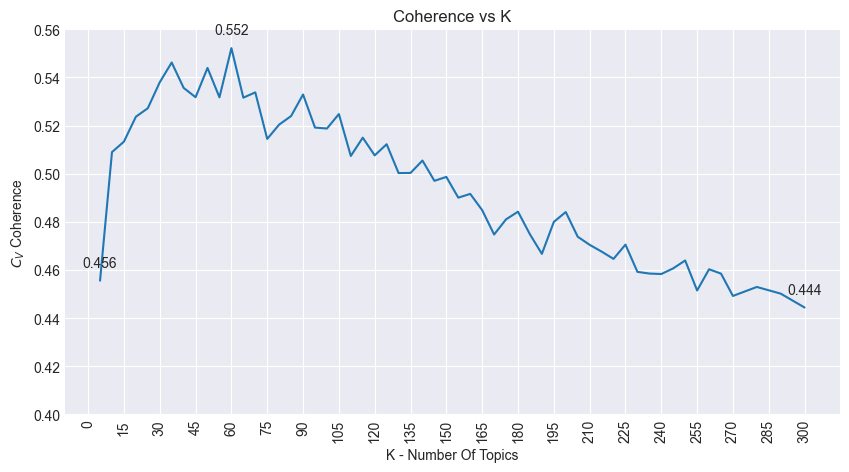

In [38]:
# PLOT RESULTS FOR K SEARCH SPACE
import os

# join all the .csv files inside the folder 'models' and join them, if a row is repeated, the coherence is the maximum
models_results = pd.concat([pd.read_csv(f'models/{file}') for file in os.listdir('models') if file.endswith('.csv') and file.startswith('lda_models_results- K')])
models_results = models_results.groupby(['df', 'tfidf', 'K', 'alpha', 'eta']).max().reset_index()
models_results.to_csv('models/lda_models_results- Ksearch_results.csv', index=False)

# line 'o-' plot the column 'coherence' versus 'K' in the csv file 'models/lda_models_results.csv' 
models_results = pd.read_csv('models/lda_models_results- Ksearch_results.csv')

plt.figure(figsize=(10, 5))
plt.plot(models_results['K'], models_results['coherence'], '-')
xticks = np.arange(0, 305, 15)
plt.xticks(xticks, rotation=90)
plt.xlabel('K - Number Of Topics')
plt.ylabel('$C_V$ Coherence')
plt.ylim(0.4, 0.56)
plt.title('Coherence vs K')

for i in range(len(models_results)):
    if i==11 or i == 0 or i == len(models_results)-1:
        plt.annotate(f"{models_results['coherence'][i]:.3f}", (models_results['K'][i], models_results['coherence'][i]), xytext=(0, 10), textcoords='offset points', ha='center')

plt.grid(True)


In [35]:
a = pd.read_csv('models/topics.csv')
a['Terms'] = a['Terms'].apply(lambda topic: ', '.join([f'{t.split("*")[-1][1:-1]}' for t in topic.split(' + ')][:5]))
a.head(30).to_excel('tables/topics1.xlsx', index=False)
a.tail(30).to_excel('tables/topics2.xlsx', index=False)
a

,Topics,Labels,Groups,Terms
0,0,Graph Theory and Network Structures,Networks,"graph, structure, node, tree, edge"
1,1,Control Systems and Dynamic Systems,Systems & Control,"control, system, time, controller, design"
2,2,Systems and Energy Management,Systems & Control,"system, power, time, energy, sensor"
3,3,Multi-level Feature Fusion and Deep Learning,DL,"multi, level, feature, module, dataset"
4,4,Probability Distribution and Estimation Algori...,Statistics,"distribution, algorithm, probability, show, es..."
5,5,Evolutionary Algorithm and Optimization,Genetic,"algorithm, optimization, search, performance, ..."
6,6,Urban Navigation and Localization,Navigation,"location, trajectory, vehicle, mobile, road"
7,7,Object Recognition and Visual Saliency,CV,"object, visual, image, scene, category"
8,8,Object Detection,CV,"detection, detect, detector, community, proposal"
9,9,Cybersecurity & Network Communication,Cybersecurity,"event, attack, service, communication, distribute"
